# Replication and extension of 'Unsupervised learning by competing hidden units'

### **Authors**

- Adam Amer
- Alessandra Bontempi

### **Introduction**

This notebook reproduces and extends results from the paper *"Unsupervised Learning by Competing Hidden Units"*, which introduces a bio-inspired unsupervised learning algorithm. 

The algorithm uses competition among hidden units, anti-Hebbian updates, and lateral inhibition to extract features without labels. We apply this algorithm to CIFAR-10 and MNIST datasets. We compare the performance of the bio-inspired method with a traditional backpropagation model on the same datasets. 

The source code for the models is in the `models.py` file.

### **Structure of the file**

1. **Reproduction of the results from MNIST**
2. **Reproduction of the results from CIFAR-10**
3. **Hyperparameter optimization**
4. **Comparing slow and fast implementation on CIFAR-10**
5. **The effect of data augmentation on CIFAR-10**
6. **From fully connected to convolutional** / **Multi-Layer learning**

In [2]:
%load_ext autoreload
%autoreload 2

# Importing necessary libraries
import torch
from models import (
    BPClassifier,
    BioClassifier,
)
from utils import (
    download_and_plot_dataset,
    hyperparameter_optimization,
    plot_hyperparameter_optimization_bars,
)

import optuna
import pandas as pd
from plotly.graph_objects import Figure
import plotly.express as px


HP_OPT_STORAGE_NAME = "sqlite:///../output/bio_classifier_hyperparam_optimization.db"

# Set random seed for reproducibility
SEED = 42
torch.manual_seed(SEED)
print("Random Seed for Torch: ", torch.initial_seed())

Random Seed for Torch:  42


In [ ]:
# Original MNIST

last_validation_error = None

for project_w in ["True", "False"]:
    model = BioClassifier(
        dataset_name="MNIST",
        unsupervised_minibatch_size=100,
        supervised_minibatch_size=100,
        hidden_size=2000,
        slow=False,
        p=3,
        delta=0.4,
        R=1,
        power_n=4.5,
        project_w=project_w,
        normalize_w_update="True",
        use_original_supervised="True",
        supervised_lr=0.001,
        unsupervised_lr=0.04,
        k=7,
        power_m_loss=6,
        beta_tanh=1.4,
        use_validation=False,
    )
    model.train_unsupervised_and_supervised(
        unsupervised_epochs=20,
        supervised_epochs=10,
        eval_every=2,
        test_supervised_epochs=2,
    )
    if last_validation_error is None:
        last_validation_error = model.supervised_validation_errors.values()[-1]
        model.save()
        model.plot_errors()
    else:
        if model.supervised_validation_errors[-1] < last_validation_error:
            last_validation_error = model.supervised_validation_errors[-1]
            model.save()
            model.plot_errors()

In [10]:
study = optuna.load_study(study_name="fast_multi_dataset", storage=HP_OPT_STORAGE_NAME)


importances = []

# 0: MNIST, 1: CIFAR-100, 2: FashionMNIST
for dataset in [0, 1, 2]:
    importances.append(
        optuna.importance.get_param_importances(
            study, target=lambda t: t.values[dataset]
        )
    )

importances_df = pd.DataFrame(importances)
importances_df = importances_df.mean(axis=0)
importances_df


def plot_importances_pie(importances_df):
    fig = px.pie(
        names=importances_df.index,
        values=importances_df.values,
        title="Parameter Importance",
    )
    fig.show()

p                              0.064040
hidden_size                    0.089588
unsupervised_epochs            0.135511
supervised_minibatch_size      0.109896
delta                          0.041816
power_n                        0.037811
unsupervised_minibatch_size    0.063641
power_m_loss                   0.032439
use_original_supervised        0.248618
beta_tanh                      0.036280
supervised_epochs              0.038987
supervised_lr                  0.028417
unsupervised_lr                0.015412
project_w                      0.028318
normalize_w_update             0.014804
k                              0.014424
dtype: float64

## Introduction to the BioClassifier model

.......

## Reproducing results from the MNIST dataset

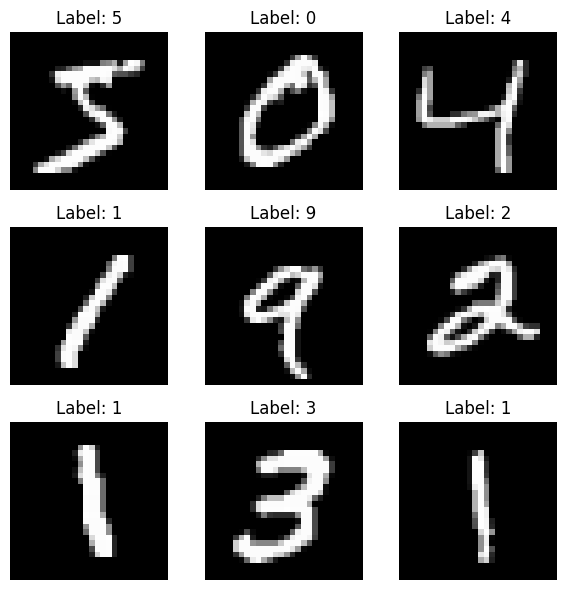

In [ ]:
download_and_plot_dataset("MNIST")

### Hyperparameter optimization

Through hyperparameter optimization, we were able to achieve a low validation error (3.41 %)

In [7]:
study_name = "fast_mnist"

try:
    initial_study = optuna.load_study(
        study_name=study_name, storage=HP_OPT_STORAGE_NAME
    )
    print(f"Study loaded with {len(initial_study.trials)} trials")
except KeyError:
    print(f"Study {study_name} not found. Creating a new one.")
    initial_study = optuna.create_study(
        study_name=study_name, storage=HP_OPT_STORAGE_NAME
    )
    initial_study.optimize(
        lambda trial: hyperparameter_optimization(
            trial=trial,
            dataset_name="MNIST",
            slow=True,
        ),
        n_trials=100,
    )

trials_df: pd.DataFrame = initial_study.trials_dataframe()

columns_mapper = {
    x: x.removeprefix("params_") for x in trials_df.columns if x.startswith("params")
}
columns_mapper["value"] = "error_rate"


trials_df = (
    trials_df.rename(columns=columns_mapper)
    .drop(
        columns=[
            "number",
            "datetime_start",
            "datetime_complete",
            "system_attrs_fixed_params",
            "state",
        ]
    )
    .dropna()
    .sort_values(by="error_rate", ascending=True)
)

fig: Figure = optuna.visualization.plot_optimization_history(initial_study)

fig.update_layout(
    title="Hyperoptimization for MNIST", yaxis_title="Validation Error Rate"
)


fig.show()

fig.write_html("../plots/fast_mnist_hyperparam_optimization.html")

# fig.write_image(file="../plots/fast_mnist_hyperparam_optimization.png")

Study loaded with 48 trials


In [ ]:
print("Best trial:")
print(trials_df.iloc[0])
print("Unsupervised Epochs: ", 100)
print("Supervised Epochs: ", 10)

Best trial:
error_rate                                   3.41
duration                   0 days 00:25:45.622715
beta_tanh                                0.956271
delta                                    0.199718
k                                               3
minibatch_size                                 55
normalize_w_update                           True
p                                               4
power_m_loss                                    9
power_n                                         5
project_w                                   False
supervised_lr                            0.019912
unsupervised_lr                          0.293331
use_original_supervised                     False
Name: 27, dtype: object
Unsupervised Epochs:  100
Supervised Epochs:  10


### Training and plotting errors with best performing model

## Reproducing results from CIFAR-10

Files already downloaded and verified


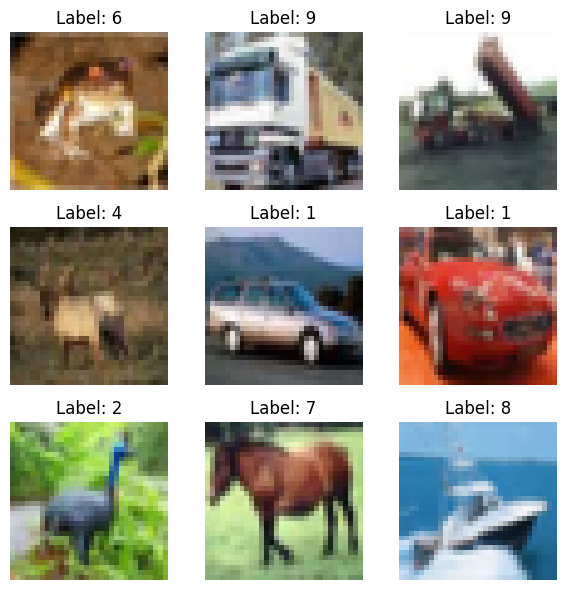

In [50]:
download_and_plot_dataset("CIFAR-10")

In [10]:
study_name = "fast_cifar"

try:
    initial_study = optuna.load_study(
        study_name=study_name, storage=HP_OPT_STORAGE_NAME
    )
    print(f"Study loaded with {len(initial_study.trials)} trials")
except KeyError:
    print(f"Study {study_name} not found. Creating a new one.")
    initial_study = optuna.create_study(
        study_name=study_name, storage=HP_OPT_STORAGE_NAME
    )
    initial_study.optimize(
        lambda trial: hyperparameter_optimization(
            trial=trial,
            dataset_name="MNIST",
            slow=True,
        ),
        n_trials=100,
    )

trials_df: pd.DataFrame = initial_study.trials_dataframe()

columns_mapper = {
    x: x.removeprefix("params_") for x in trials_df.columns if x.startswith("params")
}
columns_mapper["value"] = "error_rate"


trials_df = (
    trials_df.rename(columns=columns_mapper)
    .drop(
        columns=[
            "number",
            "datetime_start",
            "datetime_complete",
            "state",
        ]
    )
    .dropna()
    .sort_values(by="error_rate", ascending=True)
)

fig: Figure = optuna.visualization.plot_optimization_history(initial_study)

fig.update_layout(
    title="Hyperoptimization for CIFAR-10", yaxis_title="Validation Error Rate"
)


fig.show()

fig.write_html("../plots/fast_cifar10_hyperparam_optimization.html")

# fig.write_image(file="../plots/fast_mnist_hyperparam_optimization.png")

Study loaded with 29 trials


### Hyperparameter optimization

We plot the importance of each hyperparameter as computed by bayesian optimization by fANOVA.

Comparison with MNIST 

(fANOVA fits a random forest regression model that predicts the objective values of COMPLETE trials given their parameter configurations. The more accurate this model is, the more reliable the importances assessed by this class are.)

We also plot some hyperparameter against error rate values.

Some observations: ....

In [ ]:
study_name = "fast_multi_dataset"

try:
    optuna.delete_study(study_name=study_name, storage=HP_OPT_STORAGE_NAME)
except KeyError:
    pass

initial_study = optuna.create_study(
    study_name=study_name,
    storage=HP_OPT_STORAGE_NAME,
    directions=["minimize", "minimize", "minimize", "maximize", "maximize", "minimize"],
)

initial_study.set_metric_names(
    [
        "MNIST Validation Error",
        "CIFAR-100 Validation Error",
        "FashionMNIST Validation Error",
        "Mean Unsupervised Improvement",
        "Mean Supervised Improvement",
        "Time Taken",
    ]
)

initial_study.optimize(
    lambda trial: hyperparameter_optimization(
        trial=trial,
        dataset_names=["MNIST", "CIFAR-100", "FashionMNIST"],
        slow=False,
        eval_every=2,
        test_supervised_epochs=2,
    )
)

#### Slow HP Optimization

In [ ]:
fast_full_study = optuna.load_study(study_name=study_name, storage=HP_OPT_STORAGE_NAME)

trials_df: pd.DataFrame = fast_full_study.trials_dataframe()

columns_mapper = {
    x: x.removeprefix("params_") for x in trials_df.columns if x.startswith("params")
}

columns_mapper.update(
    {x: x.removeprefix("values_") for x in trials_df.columns if x.startswith("values_")}
)


trials_df = (
    trials_df.rename(columns=columns_mapper)
    .drop(
        columns=[
            "number",
            "datetime_start",
            "datetime_complete",
            "state",
        ]
    )
    .dropna()
)

trials_df["average_validation_error"] = trials_df[
    [col for col in trials_df.columns.to_list() if "Validation Error" in col]
].mean(axis=1)

trials_df = trials_df.sort_values("average_validation_error", ascending=True)

print("Best trial:", trials_df.iloc[0])

best_params = (
    trials_df.iloc[0]
    .drop(
        [
            "CIFAR-100 Validation Error",
            "FashionMNIST Validation Error",
            "MNIST Validation Error",
            "Mean Supervised Improvement",
            "Mean Unsupervised Improvement",
            "Time Taken",
            "duration",
            "system_attrs_nsga2:generation",
            "average_validation_error",
            "unsupervised_epochs",
            "supervised_epochs",
        ]
    )
    .to_dict()
)

In [ ]:
study = optuna.create_study(
    study_name="slow_multi_dataset",
    storage=HP_OPT_STORAGE_NAME,
    directions=["minimize", "minimize", "minimize", "maximize", "maximize", "minimize"],
    load_if_exists=True,
)

study.set_metric_names(
    [
        "MNIST Validation Error",
        "CIFAR-100 Validation Error",
        "FashionMNIST Validation Error",
        "Mean Unsupervised Improvement",
        "Mean Supervised Improvement",
        "Time Taken",
    ]
)

study.optimize(
    lambda x: hyperparameter_optimization(
        x,
        dataset_names=["MNIST", "CIFAR-100", "FashionMNIST"],
        slow=True,
        unsupervised_epochs=(1, trials_df.iloc[0]["unsupervised_epochs"]),
        supervised_epochs=(1, trials_df.iloc[0]["supervised_epochs"]),
        hidden_size=(best_params["hidden_size"], best_params["hidden_size"]),
        unsupervised_minibatch_size=(
            best_params["unsupervised_minibatch_size"],
            best_params["unsupervised_minibatch_size"],
        ),
        p=(best_params["p"], best_params["p"]),
        delta=(best_params["delta"], best_params["delta"]),
        power_n=(best_params["power_n"], best_params["power_n"]),
        power_m_loss=(best_params["power_m_loss"], best_params["power_m_loss"]),
        beta_tanh=(best_params["beta_tanh"], best_params["beta_tanh"]),
    ),
    catch=(ValueError,),
)

In [ ]:
optuna.visualization.plot_param_importances(initial_study).show()

### Plot importances as Pie Graph and Bars

In [ ]:
study = optuna.load_study(study_name="fast_multi_dataset", storage=HP_OPT_STORAGE_NAME)


importances = []

# 0: MNIST, 1: CIFAR-100, 2: FashionMNIST
for dataset in [0, 1, 2]:
    importances.append(
        optuna.importance.get_param_importances(
            study, target=lambda t: t.values[dataset]
        )
    )

importances_df = pd.DataFrame(importances)
importances_df = importances_df.mean(axis=0)
importances_df

fig = px.pie(
    names=importances_df.index,
    values=importances_df.values,
    title="Hyperparameters Importance",
)
fig.show()
fig.write_html("../plots/hyperparams_importance.html")
#fig.write_image("../plots/hyperparams_importance")

In [9]:
plot_hyperparameter_optimization_bars(
    trials_df=trials_df,
    hyperparameters=[
        "use_original_supervised",
        "delta",
        "beta_tanh",
        "project_w",
    ],
)

#### Data Augmentation

In [ ]:
torch.set_default_device("cuda")

model = BioClassifier("CIFAR-100", R=1, slow=False, **best_params)
model.train_unsupervised_and_supervised(
    unsupervised_epochs=trials_df.iloc[0]["unsupervised_epochs"],
    supervised_epochs=trials_df.iloc[0]["supervised_epochs"],
    eval_every=2,
    test_supervised_epochs=2,
)
model.save()

In [ ]:
model = BioClassifier("CIFAR-100-AutoAugmented", R=1, slow=False, **best_params)
model.train_unsupervised_and_supervised(
    unsupervised_epochs=trials_df.iloc[0]["unsupervised_epochs"],
    supervised_epochs=trials_df.iloc[0]["supervised_epochs"],
    eval_every=2,
    test_supervised_epochs=2,
)
model.save()
#print("Validation error:", model.supervised_validation_errors[-1])

### Plotting errors with the best set of params found

In [10]:
# Loading the best model for CIFAR-10 hyperparameter optimization
best_params = initial_study.best_params
# Ensure compatibility with the new initialization of BioClassifier
for param in ["unsupervised_minibatch_size", "supervised_minibatch_size"]:
    best_params[param] = best_params["minibatch_size"]
best_params.pop("minibatch_size")

print("Best parameters for CIFAR-10:")
print(best_params)
try:
    print("Loading the best model for CIFAR-10 hyperparameter optimization")
    model = BioClassifier.load(
        "../output/models/bioclassifier_fast/cifar-10/unsupervised_1000_supervised_300.pth"
    )
    fig = model.plot_errors()
except FileNotFoundError:
    print("Model not found. Training a new one")
    model = BioClassifier(
        dataset_name="CIFAR-10",
        hidden_size=2000,
        slow=False,
        R=1,
        **best_params,
    )
    fig = model.train_unsupervised_and_supervised(
        unsupervised_epochs=1000, supervised_epochs=300
    )
    model.save()

In [ ]:
model.draw_unsupervised_weights(3, 3)

We plot the importance of each hyperparameter as computed by bayesian optimization by fANOVA

(fANOVA fits a random forest regression model that predicts the objective values of COMPLETE trials given their parameter configurations. The more accurate this model is, the more reliable the importances assessed by this class are.)

We also plot some hyperparameter against error rate values.

Some observations: ....


In [48]:
optuna.visualization.plot_param_importances(initial_study).show()

In [49]:
plot_hyperparameter_optimization_bars(
    trials_df=trials_df,
    hyperparameters=[
        "k",
        "unsupervised_lr",
        "delta",
        "p",
        "normalize_w_update",
        "project_w",
        "use_original_supervised",
    ],
)

### The effect of data augmentation on CIFAR-10

Files already downloaded and verified


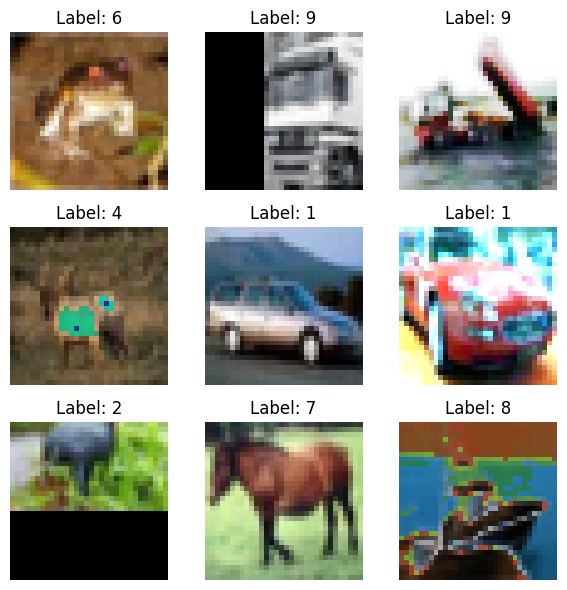

In [ ]:
download_and_plot_dataset("CIFAR-10-AutoAugmented")

In [13]:
UNSUPERVISED_EPOCHS = 50
SUPERVISED_EPOCHS = 25
EVAL_EVERY = 10

try:
    standard_model = BioClassifier.load(
        f"../output/models/bioclassifier_fast/cifar-10/unsupervised_{UNSUPERVISED_EPOCHS}_supervised_{SUPERVISED_EPOCHS}.pth"
    )
    standard_fig = standard_model.plot_errors()
except FileNotFoundError:
    standard_model = BioClassifier(
        dataset_name="CIFAR-10",
        hidden_size=2000,
        slow=False,
        R=1,
        use_validation=False,
        **best_params,
    )
    standard_fig = standard_model.train_unsupervised_and_supervised(
        unsupervised_epochs=UNSUPERVISED_EPOCHS,
        supervised_epochs=SUPERVISED_EPOCHS,
        eval_every=EVAL_EVERY,
    )
    standard_model.save()


try:
    augmented_model = BioClassifier.load(
        f"../output/models/bioclassifier_fast/cifar-10-autoaugmented/unsupervised_{UNSUPERVISED_EPOCHS}_supervised_{SUPERVISED_EPOCHS}.pth"
    )
    augmented_fig = augmented_model.plot_errors(fig=standard_fig)
except FileNotFoundError:
    augmented_model = BioClassifier(
        dataset_name="CIFAR-10-AutoAugmented",
        hidden_size=2000,
        slow=False,
        R=1,
        use_validation=False,
        **best_params,
    )
    augmented_fig = augmented_model.train_unsupervised_and_supervised(
        unsupervised_epochs=UNSUPERVISED_EPOCHS,
        supervised_epochs=SUPERVISED_EPOCHS,
        eval_every=EVAL_EVERY,
        fig=standard_fig,
    )
    augmented_model.save()

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Starting Unsupervised Learning Phase for BioClassifier_fast with LR=0.02180100966200628
Starting Supervised Learning Phase for BioClassifier_fast with LR=0.0014887696328478087


Supervised Learning Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Supervised Epoch 1 Training Avg Errors: 100.0%
Supervised Epoch 1 Test Avg Errors: 100.0%
Supervised Epoch 2 Training Avg Errors: 100.0%
Supervised Epoch 2 Test Avg Errors: 100.0%
Supervised Epoch 3 Training Avg Errors: 100.0%
Supervised Epoch 3 Test Avg Errors: 100.0%
Supervised Epoch 4 Training Avg Errors: 100.0%
Supervised Epoch 4 Test Avg Errors: 100.0%
Supervised Epoch 5 Training Avg Errors: 100.0%
Supervised Epoch 5 Test Avg Errors: 100.0%
Supervised Epoch 6 Training Avg Errors: 100.0%
Supervised Epoch 6 Test Avg Errors: 100.0%
Supervised Epoch 7 Training Avg Errors: 100.0%
Supervised Epoch 7 Test Avg Errors: 100.0%
Supervised Epoch 8 Training Avg Errors: 100.0%
Supervised Epoch 8 Test Avg Errors: 100.0%
Supervised Epoch 9 Training Avg Errors: 100.0%
Supervised Epoch 9 Test Avg Errors: 100.0%
Supervised Epoch 10 Training Avg Errors: 100.0%
Supervised Epoch 10 Test Avg Errors: 100.0%
Supervised Epoch 11 Training Avg Errors: 100.0%
Supervised Epoch 11 Test Avg Errors: 100.0%
Superv

Unsupervised Learning Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Starting Supervised Learning Phase for BioClassifier_fast with LR=0.0014887696328478087


Supervised Learning Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Supervised Epoch 1 Training Avg Errors: 99.7386%
Supervised Epoch 1 Test Avg Errors: 100.0%
Supervised Epoch 2 Training Avg Errors: 100.0%
Supervised Epoch 2 Test Avg Errors: 100.0%
Supervised Epoch 3 Training Avg Errors: 93.8228%
Supervised Epoch 3 Test Avg Errors: 91.066%
Supervised Epoch 4 Training Avg Errors: 91.0694%
Supervised Epoch 4 Test Avg Errors: 91.066%
Supervised Epoch 5 Training Avg Errors: 75.743%
Supervised Epoch 5 Test Avg Errors: 65.931%
Supervised Epoch 6 Training Avg Errors: 64.8782%
Supervised Epoch 6 Test Avg Errors: 64.814%
Supervised Epoch 7 Training Avg Errors: 64.9072%
Supervised Epoch 7 Test Avg Errors: 64.866%
Supervised Epoch 8 Training Avg Errors: 48.295%
Supervised Epoch 8 Test Avg Errors: 47.363%
Supervised Epoch 9 Training Avg Errors: 43.6796%
Supervised Epoch 9 Test Avg Errors: 38.588%
Supervised Epoch 10 Training Avg Errors: 32.3558%
Supervised Epoch 10 Test Avg Errors: 30.485%
Supervised Epoch 11 Training Avg Errors: 32.6478%
Supervised Epoch 11 Test

Supervised Learning Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Supervised Epoch 1 Training Avg Errors: 99.7606%
Supervised Epoch 1 Test Avg Errors: 100.0%
Supervised Epoch 2 Training Avg Errors: 98.5174%
Supervised Epoch 2 Test Avg Errors: 97.792%
Supervised Epoch 3 Training Avg Errors: 98.6632%
Supervised Epoch 3 Test Avg Errors: 99.495%
Supervised Epoch 4 Training Avg Errors: 94.322%
Supervised Epoch 4 Test Avg Errors: 91.081%
Supervised Epoch 5 Training Avg Errors: 83.57%
Supervised Epoch 5 Test Avg Errors: 82.278%
Supervised Epoch 6 Training Avg Errors: 78.0712%
Supervised Epoch 6 Test Avg Errors: 73.556%
Supervised Epoch 7 Training Avg Errors: 66.6266%
Supervised Epoch 7 Test Avg Errors: 64.607%
Supervised Epoch 8 Training Avg Errors: 64.6822%
Supervised Epoch 8 Test Avg Errors: 64.644%
Supervised Epoch 9 Training Avg Errors: 48.072%
Supervised Epoch 9 Test Avg Errors: 47.172%
Supervised Epoch 10 Training Avg Errors: 38.1516%
Supervised Epoch 10 Test Avg Errors: 29.517%
Supervised Epoch 11 Training Avg Errors: 29.8514%
Supervised Epoch 11 Tes

Supervised Learning Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Supervised Epoch 1 Training Avg Errors: 99.134%
Supervised Epoch 1 Test Avg Errors: 100.0%
Supervised Epoch 2 Training Avg Errors: 97.2626%
Supervised Epoch 2 Test Avg Errors: 93.77%
Supervised Epoch 3 Training Avg Errors: 92.8254%
Supervised Epoch 3 Test Avg Errors: 85.361%
Supervised Epoch 4 Training Avg Errors: 85.7728%
Supervised Epoch 4 Test Avg Errors: 86.266%
Supervised Epoch 5 Training Avg Errors: 77.9016%
Supervised Epoch 5 Test Avg Errors: 70.679%
Supervised Epoch 6 Training Avg Errors: 64.2238%
Supervised Epoch 6 Test Avg Errors: 64.88%
Supervised Epoch 7 Training Avg Errors: 46.4626%
Supervised Epoch 7 Test Avg Errors: 38.168%
Supervised Epoch 8 Training Avg Errors: 38.0052%
Supervised Epoch 8 Test Avg Errors: 35.382%
Supervised Epoch 9 Training Avg Errors: 37.8072%
Supervised Epoch 9 Test Avg Errors: 39.149%
Supervised Epoch 10 Training Avg Errors: 23.6976%
Supervised Epoch 10 Test Avg Errors: 13.486%
Supervised Epoch 11 Training Avg Errors: 17.2256%
Supervised Epoch 11 Te

Supervised Learning Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Supervised Epoch 1 Training Avg Errors: 99.7608%
Supervised Epoch 1 Test Avg Errors: 100.0%
Supervised Epoch 2 Training Avg Errors: 100.0%
Supervised Epoch 2 Test Avg Errors: 100.0%
Supervised Epoch 3 Training Avg Errors: 99.43%
Supervised Epoch 3 Test Avg Errors: 93.047%
Supervised Epoch 4 Training Avg Errors: 88.4794%
Supervised Epoch 4 Test Avg Errors: 85.872%
Supervised Epoch 5 Training Avg Errors: 88.5108%
Supervised Epoch 5 Test Avg Errors: 91.168%
Supervised Epoch 6 Training Avg Errors: 74.4922%
Supervised Epoch 6 Test Avg Errors: 73.331%
Supervised Epoch 7 Training Avg Errors: 61.2882%
Supervised Epoch 7 Test Avg Errors: 47.539%
Supervised Epoch 8 Training Avg Errors: 45.328%
Supervised Epoch 8 Test Avg Errors: 37.663%
Supervised Epoch 9 Training Avg Errors: 36.258%
Supervised Epoch 9 Test Avg Errors: 28.719%
Supervised Epoch 10 Training Avg Errors: 28.1622%
Supervised Epoch 10 Test Avg Errors: 20.049%
Supervised Epoch 11 Training Avg Errors: 20.1704%
Supervised Epoch 11 Test A

Supervised Learning Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Supervised Epoch 1 Training Avg Errors: 99.1228%
Supervised Epoch 1 Test Avg Errors: 100.0%
Supervised Epoch 2 Training Avg Errors: 100.0%
Supervised Epoch 2 Test Avg Errors: 100.0%
Supervised Epoch 3 Training Avg Errors: 100.0%
Supervised Epoch 3 Test Avg Errors: 100.0%
Supervised Epoch 4 Training Avg Errors: 96.325%
Supervised Epoch 4 Test Avg Errors: 94.742%
Supervised Epoch 5 Training Avg Errors: 95.0332%
Supervised Epoch 5 Test Avg Errors: 95.376%
Supervised Epoch 6 Training Avg Errors: 95.9406%
Supervised Epoch 6 Test Avg Errors: 96.694%
Supervised Epoch 7 Training Avg Errors: 83.0176%
Supervised Epoch 7 Test Avg Errors: 84.302%
Supervised Epoch 8 Training Avg Errors: 70.9202%
Supervised Epoch 8 Test Avg Errors: 68.104%
Supervised Epoch 9 Training Avg Errors: 61.7094%
Supervised Epoch 9 Test Avg Errors: 64.408%
Supervised Epoch 10 Training Avg Errors: 39.8282%
Supervised Epoch 10 Test Avg Errors: 20.065%
Supervised Epoch 11 Training Avg Errors: 20.0986%
Supervised Epoch 11 Test A

Supervised Learning Epochs:   0%|          | 0/25 [00:00<?, ?it/s]

Supervised Epoch 1 Training Avg Errors: 98.8756%
Supervised Epoch 1 Test Avg Errors: 99.981%
Supervised Epoch 2 Training Avg Errors: 99.9994%
Supervised Epoch 2 Test Avg Errors: 100.0%
Supervised Epoch 3 Training Avg Errors: 92.5468%
Supervised Epoch 3 Test Avg Errors: 92.108%
Supervised Epoch 4 Training Avg Errors: 92.274%
Supervised Epoch 4 Test Avg Errors: 92.237%
Supervised Epoch 5 Training Avg Errors: 92.4348%
Supervised Epoch 5 Test Avg Errors: 92.457%
Supervised Epoch 6 Training Avg Errors: 83.6456%
Supervised Epoch 6 Test Avg Errors: 77.719%
Supervised Epoch 7 Training Avg Errors: 62.0278%
Supervised Epoch 7 Test Avg Errors: 54.793%
Supervised Epoch 8 Training Avg Errors: 59.1204%
Supervised Epoch 8 Test Avg Errors: 46.459%
Supervised Epoch 9 Training Avg Errors: 35.1674%
Supervised Epoch 9 Test Avg Errors: 30.138%
Supervised Epoch 10 Training Avg Errors: 31.2078%
Supervised Epoch 10 Test Avg Errors: 33.253%
Supervised Epoch 11 Training Avg Errors: 30.7606%
Supervised Epoch 11 

Model saved to ../output/models/bioclassifier_fast/cifar-10
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Starting Unsupervised Learning Phase for BioClassifier_fast with LR=0.02180100966200628
Starting Supervised Learning Phase for BioClassifier_fast with LR=0.0014887696328478087


Supervised Learning Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Supervised Epoch 1 Training Avg Errors: 100.0%
Supervised Epoch 1 Test Avg Errors: 100.0%
Supervised Epoch 2 Training Avg Errors: 100.0%
Supervised Epoch 2 Test Avg Errors: 100.0%
Supervised Epoch 3 Training Avg Errors: 100.0%
Supervised Epoch 3 Test Avg Errors: 100.0%
Supervised Epoch 4 Training Avg Errors: 100.0%
Supervised Epoch 4 Test Avg Errors: 100.0%
Supervised Epoch 5 Training Avg Errors: 100.0%
Supervised Epoch 5 Test Avg Errors: 100.0%
Supervised Epoch 6 Training Avg Errors: 100.0%
Supervised Epoch 6 Test Avg Errors: 100.0%
Supervised Epoch 7 Training Avg Errors: 100.0%
Supervised Epoch 7 Test Avg Errors: 100.0%
Supervised Epoch 8 Training Avg Errors: 100.0%
Supervised Epoch 8 Test Avg Errors: 100.0%
Supervised Epoch 9 Training Avg Errors: 100.0%
Supervised Epoch 9 Test Avg Errors: 100.0%
Supervised Epoch 10 Training Avg Errors: 100.0%
Supervised Epoch 10 Test Avg Errors: 100.0%
Supervised Epoch 11 Training Avg Errors: 100.0%
Supervised Epoch 11 Test Avg Errors: 100.0%
Superv

Unsupervised Learning Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Starting Supervised Learning Phase for BioClassifier_fast with LR=0.0014887696328478087


Supervised Learning Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Supervised Epoch 1 Training Avg Errors: 100.0%
Supervised Epoch 1 Test Avg Errors: 100.0%
Supervised Epoch 2 Training Avg Errors: 100.0%
Supervised Epoch 2 Test Avg Errors: 100.0%
Supervised Epoch 3 Training Avg Errors: 100.0%
Supervised Epoch 3 Test Avg Errors: 100.0%
Supervised Epoch 4 Training Avg Errors: 100.0%
Supervised Epoch 4 Test Avg Errors: 100.0%
Supervised Epoch 5 Training Avg Errors: 100.0%
Supervised Epoch 5 Test Avg Errors: 100.0%
Supervised Epoch 6 Training Avg Errors: 100.0%
Supervised Epoch 6 Test Avg Errors: 100.0%
Supervised Epoch 7 Training Avg Errors: 100.0%
Supervised Epoch 7 Test Avg Errors: 100.0%
Supervised Epoch 8 Training Avg Errors: 100.0%
Supervised Epoch 8 Test Avg Errors: 100.0%
Supervised Epoch 9 Training Avg Errors: 100.0%
Supervised Epoch 9 Test Avg Errors: 100.0%
Supervised Epoch 10 Training Avg Errors: 100.0%
Supervised Epoch 10 Test Avg Errors: 100.0%
Supervised Epoch 11 Training Avg Errors: 100.0%
Supervised Epoch 11 Test Avg Errors: 100.0%
Superv

Supervised Learning Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Supervised Epoch 1 Training Avg Errors: 100.0%
Supervised Epoch 1 Test Avg Errors: 100.0%
Supervised Epoch 2 Training Avg Errors: 100.0%
Supervised Epoch 2 Test Avg Errors: 100.0%
Supervised Epoch 3 Training Avg Errors: 100.0%
Supervised Epoch 3 Test Avg Errors: 100.0%
Supervised Epoch 4 Training Avg Errors: 100.0%
Supervised Epoch 4 Test Avg Errors: 100.0%
Supervised Epoch 5 Training Avg Errors: 100.0%
Supervised Epoch 5 Test Avg Errors: 100.0%
Supervised Epoch 6 Training Avg Errors: 100.0%
Supervised Epoch 6 Test Avg Errors: 100.0%
Supervised Epoch 7 Training Avg Errors: 100.0%
Supervised Epoch 7 Test Avg Errors: 100.0%
Supervised Epoch 8 Training Avg Errors: 100.0%
Supervised Epoch 8 Test Avg Errors: 100.0%
Supervised Epoch 9 Training Avg Errors: 100.0%
Supervised Epoch 9 Test Avg Errors: 100.0%
Supervised Epoch 10 Training Avg Errors: 100.0%
Supervised Epoch 10 Test Avg Errors: 100.0%
Supervised Epoch 11 Training Avg Errors: 100.0%
Supervised Epoch 11 Test Avg Errors: 100.0%
Superv

Supervised Learning Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Supervised Epoch 1 Training Avg Errors: 100.0%
Supervised Epoch 1 Test Avg Errors: 100.0%
Supervised Epoch 2 Training Avg Errors: 100.0%
Supervised Epoch 2 Test Avg Errors: 100.0%
Supervised Epoch 3 Training Avg Errors: 100.0%
Supervised Epoch 3 Test Avg Errors: 100.0%
Supervised Epoch 4 Training Avg Errors: 100.0%
Supervised Epoch 4 Test Avg Errors: 100.0%
Supervised Epoch 5 Training Avg Errors: 100.0%
Supervised Epoch 5 Test Avg Errors: 100.0%
Supervised Epoch 6 Training Avg Errors: 100.0%
Supervised Epoch 6 Test Avg Errors: 100.0%
Supervised Epoch 7 Training Avg Errors: 100.0%
Supervised Epoch 7 Test Avg Errors: 100.0%
Supervised Epoch 8 Training Avg Errors: 100.0%
Supervised Epoch 8 Test Avg Errors: 100.0%
Supervised Epoch 9 Training Avg Errors: 100.0%
Supervised Epoch 9 Test Avg Errors: 100.0%
Supervised Epoch 10 Training Avg Errors: 100.0%
Supervised Epoch 10 Test Avg Errors: 100.0%
Supervised Epoch 11 Training Avg Errors: 100.0%
Supervised Epoch 11 Test Avg Errors: 100.0%
Superv

Supervised Learning Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Supervised Epoch 1 Training Avg Errors: 100.0%
Supervised Epoch 1 Test Avg Errors: 100.0%
Supervised Epoch 2 Training Avg Errors: 100.0%
Supervised Epoch 2 Test Avg Errors: 100.0%
Supervised Epoch 3 Training Avg Errors: 100.0%
Supervised Epoch 3 Test Avg Errors: 100.0%
Supervised Epoch 4 Training Avg Errors: 100.0%
Supervised Epoch 4 Test Avg Errors: 100.0%
Supervised Epoch 5 Training Avg Errors: 100.0%
Supervised Epoch 5 Test Avg Errors: 100.0%
Supervised Epoch 6 Training Avg Errors: 100.0%
Supervised Epoch 6 Test Avg Errors: 100.0%
Supervised Epoch 7 Training Avg Errors: 100.0%
Supervised Epoch 7 Test Avg Errors: 100.0%
Supervised Epoch 8 Training Avg Errors: 100.0%
Supervised Epoch 8 Test Avg Errors: 100.0%
Supervised Epoch 9 Training Avg Errors: 100.0%
Supervised Epoch 9 Test Avg Errors: 100.0%
Supervised Epoch 10 Training Avg Errors: 100.0%
Supervised Epoch 10 Test Avg Errors: 100.0%
Supervised Epoch 11 Training Avg Errors: 100.0%
Supervised Epoch 11 Test Avg Errors: 100.0%
Superv

KeyboardInterrupt: 